## Loading and Understanding Data

In [172]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import math
from sklearn import preprocessing

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

# Trainng Samples loaded from Github Repo
train_path = 'https://raw.githubusercontent.com/usef-kh/HousePriceEstimation/master/Data/train.csv'
train = pd.read_csv(train_path)

# Testing Samples loaded from Github Repo
test_path = 'https://raw.githubusercontent.com/usef-kh/HousePriceEstimation/master/Data/test.csv'
test = pd.read_csv(test_path)


print(train.shape)
print(test.shape)

#Concatenating dataframs
frames = [train,test]
train = pd.concat(frames, keys=['train', 'test'],sort=False)

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
# quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

print(quantitative)
print(qualitative)

(1460, 81)
(1459, 80)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinis

In [54]:


y = ['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

SyntaxError: ignored

In [58]:
train['train']

KeyError: ignored

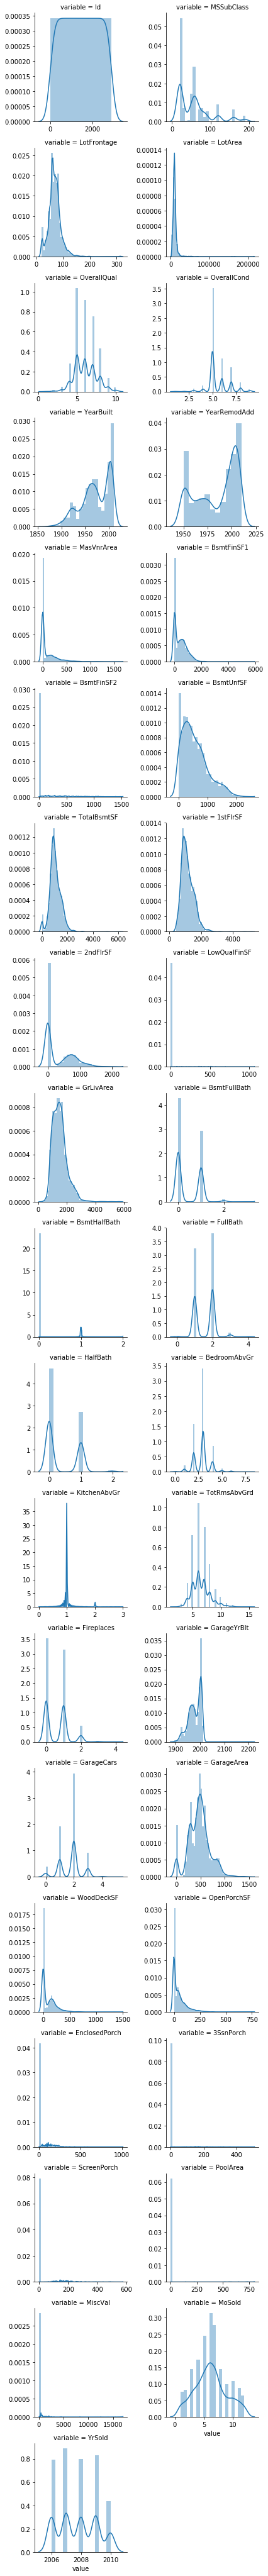

In [173]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


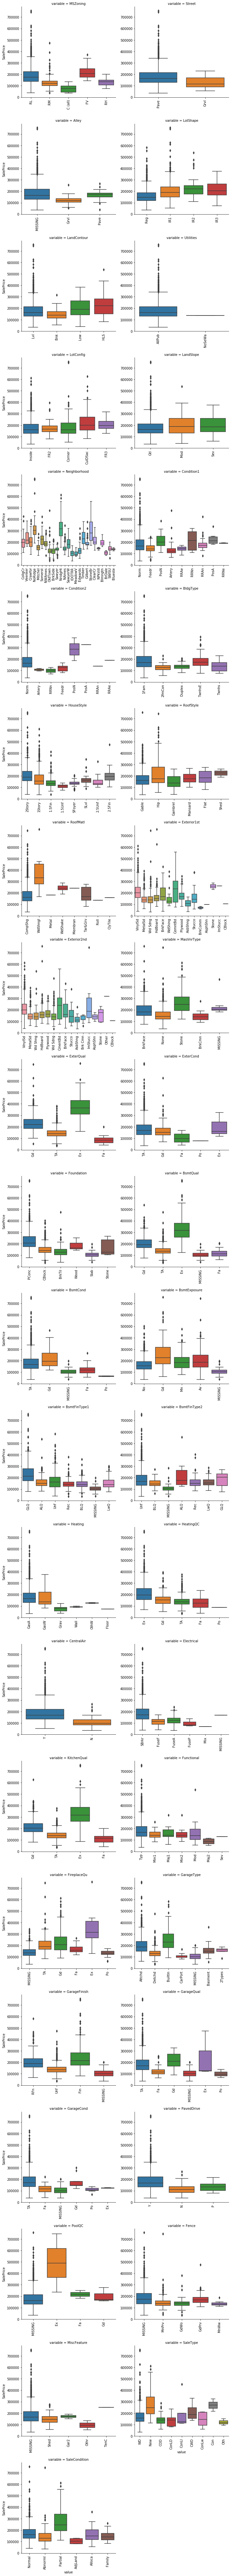

In [174]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot,
          "value", "SalePrice")


In [175]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [74]:
print(len(quantitative))
print(train)

37
              Id  MSSubClass MSZoning  LotFrontage  LotArea Street    Alley  \
train 0        1          60       RL         65.0     8450   Pave  MISSING   
      1        2          20       RL         80.0     9600   Pave  MISSING   
      2        3          60       RL         68.0    11250   Pave  MISSING   
      3        4          70       RL         60.0     9550   Pave  MISSING   
      4        5          60       RL         84.0    14260   Pave  MISSING   
      5        6          50       RL         85.0    14115   Pave  MISSING   
      6        7          20       RL         75.0    10084   Pave  MISSING   
      7        8          60       RL          NaN    10382   Pave  MISSING   
      8        9          50       RM         51.0     6120   Pave  MISSING   
      9       10         190       RL         50.0     7420   Pave  MISSING   
      10      11          20       RL         70.0    11200   Pave  MISSING   
      11      12          60       RL         85.

## Processing Data

In [0]:
def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)


boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

features = quantitative + qual_encoded + boolean 

X = train[features].fillna(0.).values
Y = np.log(train['SalePrice'].values)

X_samples = X[X[:,0] < 1461][:,1:]
x_train = X_samples[0:1461,:]
# x_val = X_samples[1165:1461,:]
x_test =X[X[:,0] >= 1461][:,1:]

In [183]:
scaler = preprocessing.MinMaxScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

y_train = Y[0:1165]
y_val = Y[1165:1460]


print('Training size:' + str(x_train.shape))
print('Validation size: ' + str(x_val.shape))
print('Testing size: ' + str(x_test.shape))
print('Total size: ' + str(x_train.shape[0] + x_val.shape[0] + x_test.shape[0] ))

print('-------------')
print('Y_train: ' + str(y_train.shape))
print('Y_val: ' + str(y_val.shape))
print('Y_total: ' + str(y_val.shape[0] + y_train.shape[0] ))

Training size:(1460, 87)
Validation size: (295, 87)
Testing size: (1459, 87)
Total size: 3214
-------------
Y_train: (1460,)
Y_val: (295,)
Y_total: 1755


In [184]:
from keras import models
from keras import layers
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
          loss = root_mean_squared_error,
          metrics=['mse'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 128)               11264     
_________________________________________________________________
dense_252 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_253 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_254 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_255 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_256 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_257 (Dense)            (None, 256)             

In [185]:
history = model.fit(x = x_train,
              y = y_train,
              validation_data=(x_val,y_val),
              epochs=179,
              batch_size=16,
#               validation_split=0.3,
              verbose=1)

# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)

Epoch 1/179
1460/1460 [==============================] - 3s 2ms/step - loss: 2.2370 - mean_squared_error: 11.7604
Epoch 2/179
1460/1460 [==============================] - 1s 354us/step - loss: 0.6513 - mean_squared_error: 0.5657
Epoch 3/179
1460/1460 [==============================] - 0s 337us/step - loss: 0.6156 - mean_squared_error: 0.5022
Epoch 4/179
1460/1460 [==============================] - 0s 339us/step - loss: 0.6667 - mean_squared_error: 0.6247
Epoch 5/179
1460/1460 [==============================] - 0s 332us/step - loss: 0.5953 - mean_squared_error: 0.4966
Epoch 6/179
1460/1460 [==============================] - 1s 347us/step - loss: 0.7912 - mean_squared_error: 0.7991
Epoch 7/179
1460/1460 [==============================] - 0s 337us/step - loss: 0.3763 - mean_squared_error: 0.1608
Epoch 8/179
1460/1460 [==============================] - 0s 341us/step - loss: 0.6939 - mean_squared_error: 0.5892
Epoch 9/179
1460/1460 [==============================] - 0s 337us/step - loss: 0.

NameError: ignored

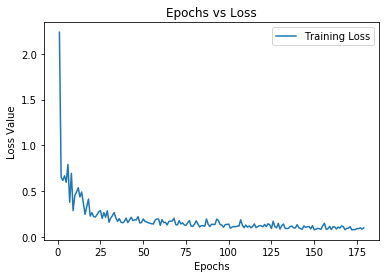

In [187]:
def loss_curve(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  x_axis     = range(1, len(history.history['loss'])+1)
  
  plt.figure()
  plt.plot(x_axis, train_loss, label="Training Loss")
  plt.plot(x_axis, val_loss, label="Validation Loss")
  plt.ylabel('Loss Value')
  plt.xlabel('Epochs')
  plt.title('Epochs vs Loss')
  plt.legend()
  print('Minimum Validation Loss is:' + str(min(val_loss)))
  print('Epoch: ' + str(val_loss.index(min(val_loss))))
  
loss_curve(history)

In [0]:
results = np.exp(model.predict(x_test))

In [189]:
print(results)

[[107113.984]
 [152648.62 ]
 [171106.3  ]
 ...
 [148672.34 ]
 [103671.21 ]
 [182190.   ]]


In [0]:
pd.DataFrame(results).to_csv("file.csv")